# Train du modèle

Ici nous allons entraîner notre modèle général. Ce modèle est entrainé sur l'ensemble des voitures.

### Importation des bibliothèques

In [1]:
!pip install captum
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from typing import Tuple

import torch
from torchvision import datasets, transforms
from torchvision.transforms import autoaugment
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import seaborn as sns
import os
from tqdm import tqdm
import shutil
import time
import networkx as nx
import PIL.Image as Image
from captum.attr import Occlusion
from captum.attr import visualization as viz

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import GradCAMpp
from torchcam.utils import overlay_mask

2024-04-24 19:09:32.034150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 19:09:32.034273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 19:09:32.175967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setup du device pour entrainement sur gpu

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Récupération des données et préparation du dataset

### Concaténation des données afin de créer un dataset général

In [4]:
if not os.path.exists("final/full"):
    os.makedirs("final/full")

class_folders_train = os.listdir("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train")
class_folders_test = os.listdir("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test")
for class_folder in class_folders_train:
    if not os.path.exists(f"final/full/{class_folder}"):
        os.makedirs(f"final/full/{class_folder}")
    for image in os.listdir(f"/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/{class_folder}"):
        img_name = image.split(".")
        img_name[0] = img_name[0] + "_train"
        image_train = ".".join(img_name)
        shutil.copy(f"/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/{class_folder}/{image}", f"final/full/{class_folder}/{image_train}")
for class_folder in class_folders_test:
    if not os.path.exists(f"final/full/{class_folder}"):
        os.makedirs(f"final/full/{class_folder}")
    for image in os.listdir(f"/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/{class_folder}"):
        img_name = image.split(".")
        img_name[0] = img_name[0] + "_test"
        image_test = ".".join(img_name)
        shutil.copy(f"/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/{class_folder}/{image}", f"final/full/{class_folder}/{image_test}")

### Création du dataset avec le bonne taille de train/test set

In [5]:
train_size = 0.8
test_size = 1 - train_size

if not os.path.exists("final/train"):
    os.makedirs("final/train")
if not os.path.exists("final/test"):
    os.makedirs("final/test")

# Take train_size of the data for training and test_size for testing
for class_folder in class_folders_train:
    if not os.path.exists(f"final/train/{class_folder}"):
        os.makedirs(f"final/train/{class_folder}")
    if not os.path.exists(f"final/test/{class_folder}"):
        os.makedirs(f"final/test/{class_folder}")
    images = os.listdir(f"final/full/{class_folder}")
    train_images = images[:int(len(images)*train_size)]
    test_images = images[int(len(images)*train_size):]
    for image in train_images:
        shutil.copy(f"final/full/{class_folder}/{image}", f"final/train/{class_folder}/{image}")
    for image in test_images:
        shutil.copy(f"final/full/{class_folder}/{image}", f"final/test/{class_folder}/{image}")

### Récupération des labels du dataset

In [6]:
df_names_generic = pd.read_csv('/kaggle/input/stanford-car-dataset-by-classes-folder/names.csv', names=['name'])

### Définition des hyperparamètres

In [7]:
batch_size_generic = 32
epochs_generic = 1

### Définition des transformations appliquées sur les données

In [8]:
train_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Création du jeu de donnée

In [9]:
#Chargement des images dans des datasets
path_test = 'final/test'
path_train = 'final/train'

train_dataset = datasets.ImageFolder(root=path_train, transform = train_tfms)

test_dataset = datasets.ImageFolder(root=path_test, transform = test_tfms)

print(f'Train dataset size is {len(train_dataset)}')
print(f'Test dataset size is {len(test_dataset)}')

Train dataset size is 12873
Test dataset size is 3312


In [10]:
#Convertion des datasets en dataLoader
train_loader_generic = DataLoader(train_dataset, batch_size = batch_size_generic, shuffle=True, num_workers = 2)
test_loader_generic = DataLoader(test_dataset, batch_size = batch_size_generic, shuffle=False, num_workers = 2)

### Chargement du modèle

In [11]:
no_classes_generic = len(train_dataset.classes) # Nombre de classes
model_generic = models.resnet18(pretrained=True)
num_ftrs = model_generic.fc.in_features

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s] 


#### Changememt du dernier layer pour l'adapté à notre problématique

In [12]:
model_generic.fc = nn.Linear(num_ftrs, no_classes_generic)
model_generic = model_generic.to(device)

# Définition de la fonction de Loss et de l'optimisation
criterion_generic = nn.CrossEntropyLoss()
optimizer_generic = optim.SGD(model_generic.parameters(), lr=0.01, momentum=0.9)

lrscheduler_generic = optim.lr_scheduler.ReduceLROnPlateau(optimizer_generic, mode='max', patience=3, threshold = 0.9)

### Définition des fonctions de train et d'évaluation

In [13]:
def eval_model(model, test_loader, device, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader), 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    test_acc = 100.0 * correct / total
    print('Accuracy sur le dataset de test: %d %%' % (
        test_acc))
    return test_acc

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        
        for i, data in enumerate(tqdm(train_loader), 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==preds).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Fin entraînement')
    return model, losses, accuracies, test_accuracies

### Entrainement du modèle

In [14]:
model_generic, training_losses, training_accs, test_accs = train_model(model_generic, train_loader_generic, 
                            test_loader_generic, criterion_generic, optimizer_generic, lrscheduler_generic, device, n_epochs=epochs_generic)

100%|██████████| 403/403 [02:25<00:00,  2.78it/s]


Epoch 1, duration: 145 s, loss: 3.8968, acc: 19.1222


100%|██████████| 104/104 [00:32<00:00,  3.19it/s]

Accuracy sur le dataset de test: 36 %
Fin entraînement


### Affichage des résultats de l'entrainement

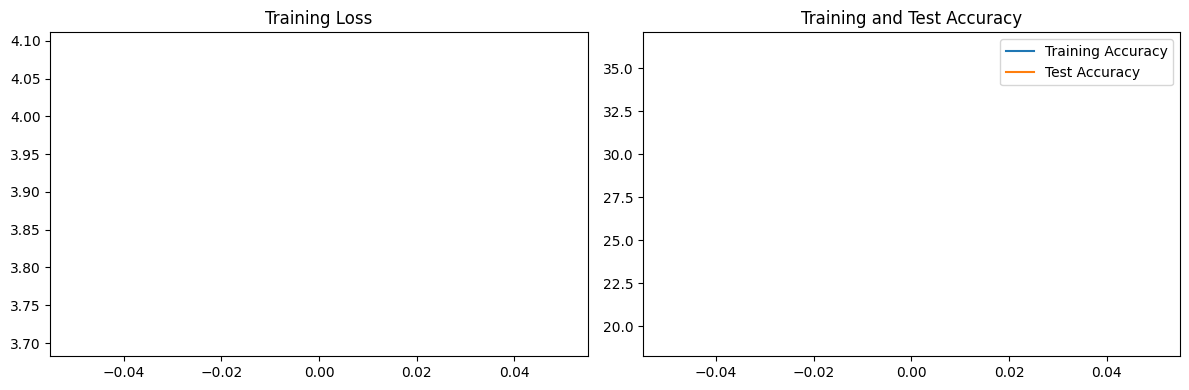

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

### Sauvegarde du modèle

In [21]:
torch.save(model_generic.state_dict(), 'model.pth')

### Évaluation du modèle

Text(0.5, 80.7222222222222, 'Predicted label')

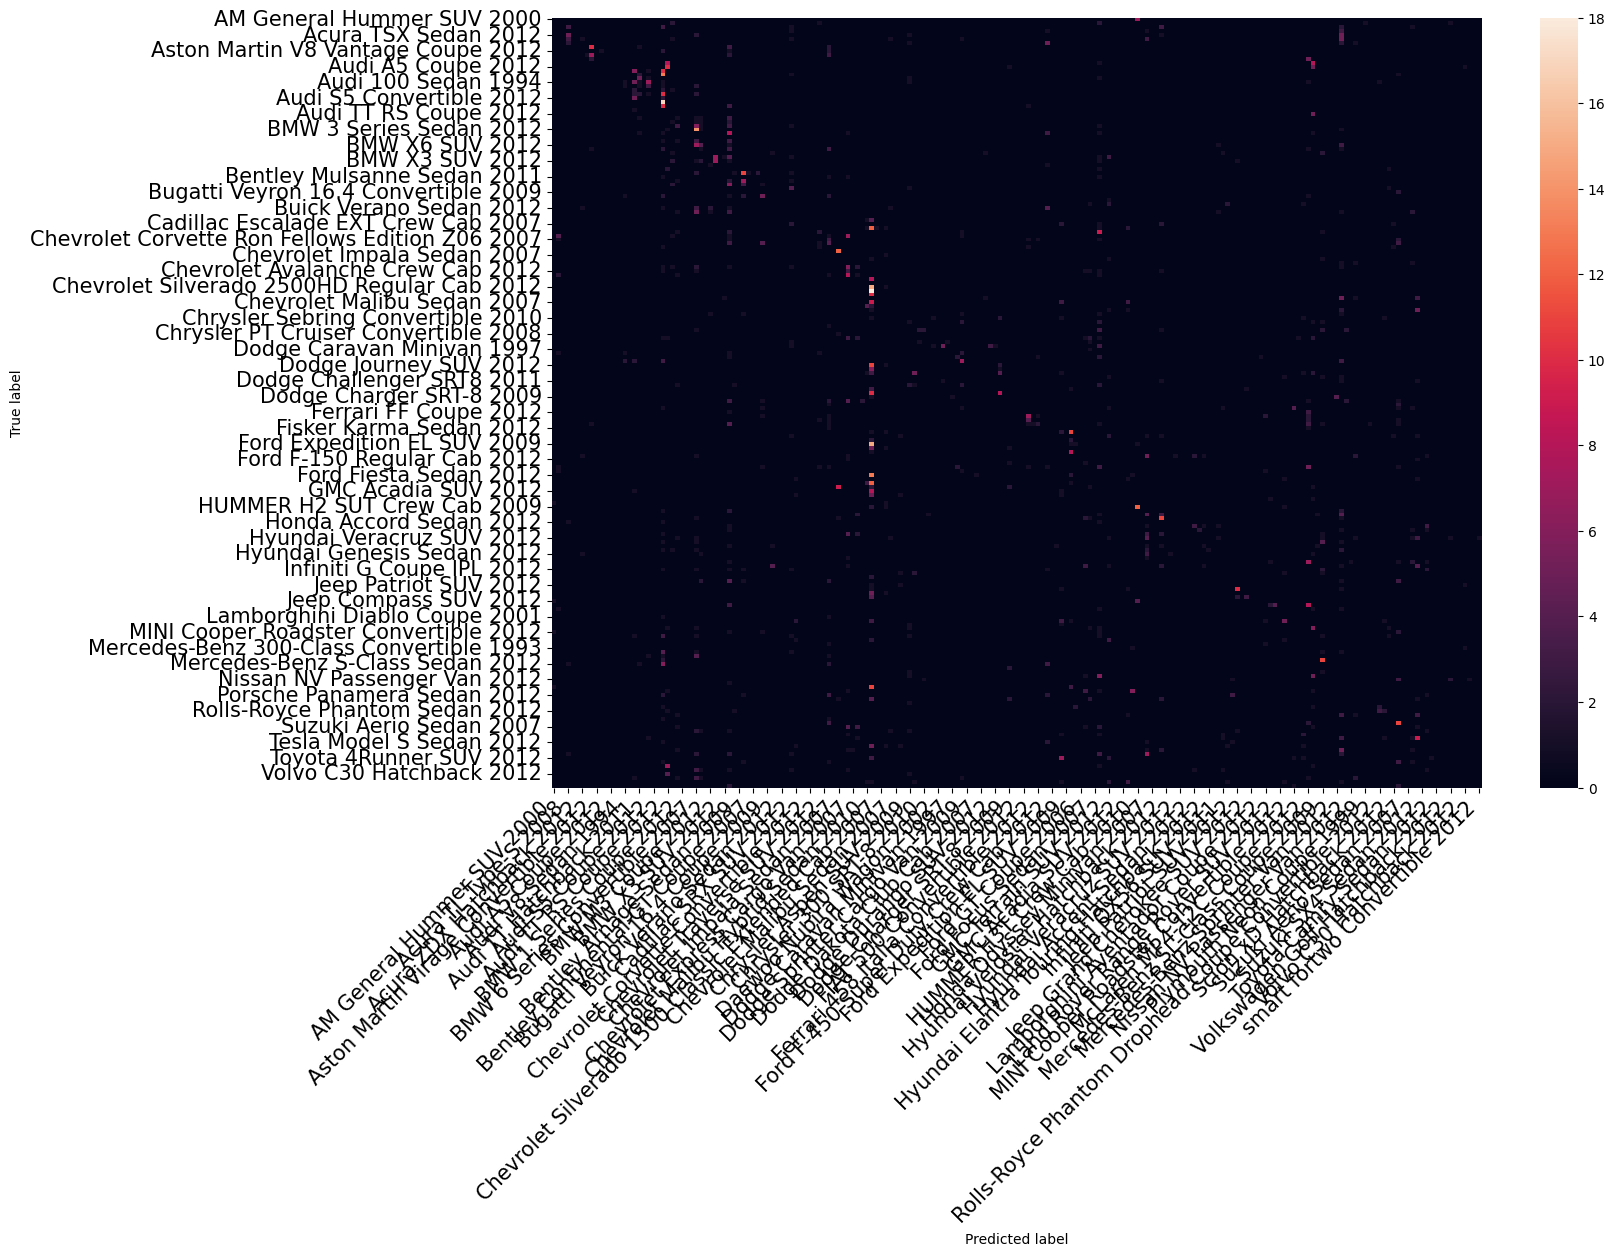

In [22]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader_generic:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_generic(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15,10))

class_names = list(df_names_generic['name'])

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
#Set the diagonal to zero, so we can see the other values better
for i in range(len(df_cm)):
    df_cm.iat[i, i] = 0
heatmap = sns.heatmap(df_cm)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Explicabilité du modèle

In [27]:
model_generic.eval() # Changement du modèle en mode évaluation

loader = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = '/kaggle/working/final/train/Chevrolet Silverado 1500 Extended Cab 2012/02365_train.jpg' #mettre une vraie image random et intégrer l'explicabilité ici
image = Image.open(random_image_name)

img = loader(image).float()
img = torch.autograd.Variable(img, requires_grad=True)
img = img.unsqueeze(0)
img = img.cuda()



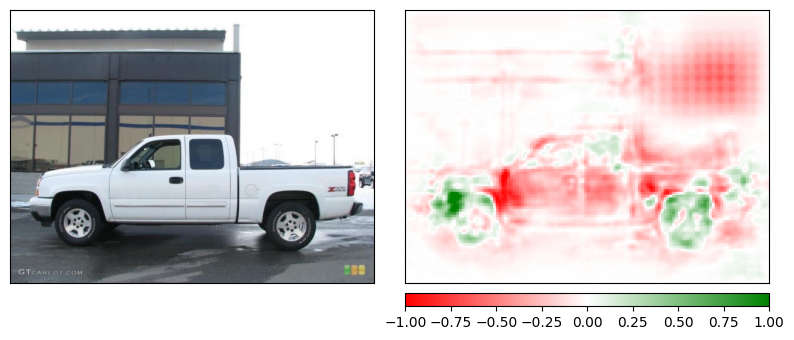

In [28]:
output = model_generic(img)
output = F.softmax(output, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
occlusion = Occlusion(model_generic)

attributions_occ = occlusion.attribute(img,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ, (1,2,0)),
                             original_image=np.asarray(image),
                             methods=["original_image","heat_map"],
                             signs=["all","all"],
                             show_colorbar=True)

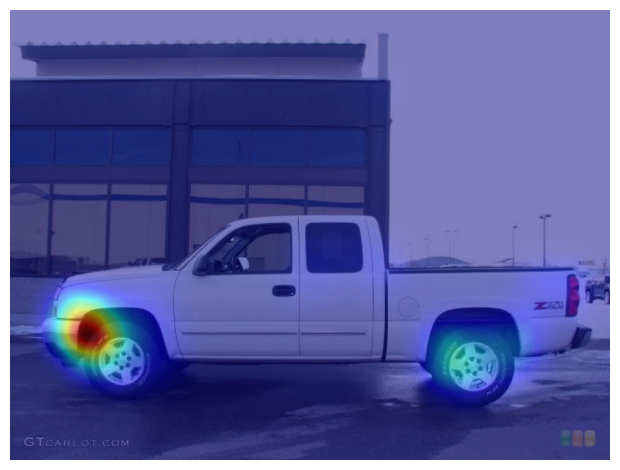

In [29]:
with GradCAMpp(model_generic) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model_generic(img)
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(image, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

# Visualisation des résultats du modèle

In [30]:
dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/names.csv"
classes = np.genfromtxt(dir, delimiter=',', dtype=str)

In [31]:
cm_copy = cm.copy()
cm_copy[cm_copy < 3] = 0
G = nx.from_numpy_array(cm_copy)
composantes_connexes = list(nx.connected_components(G))
composantes_connexes = [[e for e in s] for s in composantes_connexes]

In [32]:
sub_cms = [
    cm[sub,:][:,sub]
    for sub in composantes_connexes
]
sub_classes = [
    classes[sub]
    for sub in composantes_connexes
]

In [33]:
def show_cm(cm, classes, diag_zero = False, ax=None, show=True, rotation=None):
    cm_copy = cm.copy()
    if diag_zero:
        np.fill_diagonal(cm_copy, 0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_copy, display_labels=classes)

    disp.plot(ax=ax)
    
    if rotation:
        plt.xticks(rotation=rotation)
    if show:
        plt.show()

def show_cm_with_without_diag(cm, clases):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    show_cm(cm, classes, ax=axes[0], show=False)
    show_cm(cm, classes, diag_zero=True, ax=axes[1])

nb classes : 9


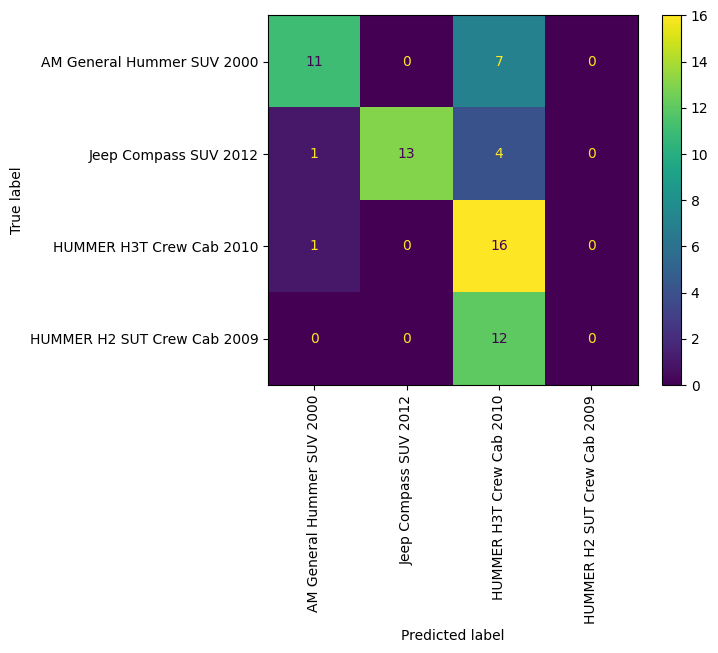

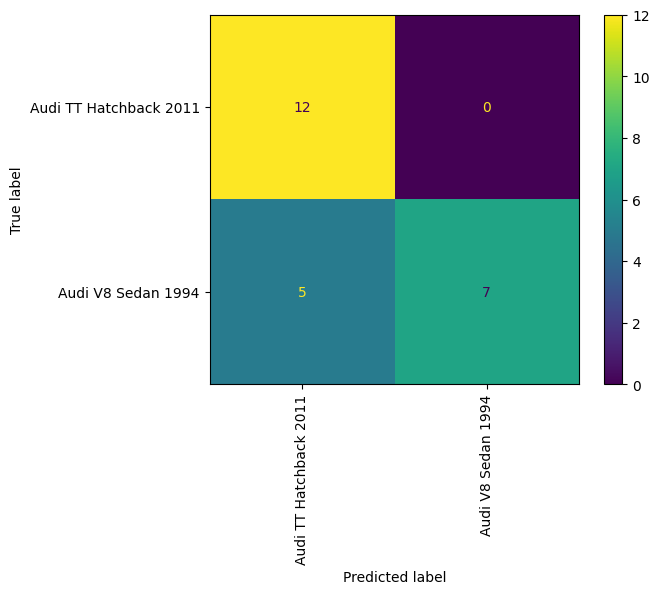

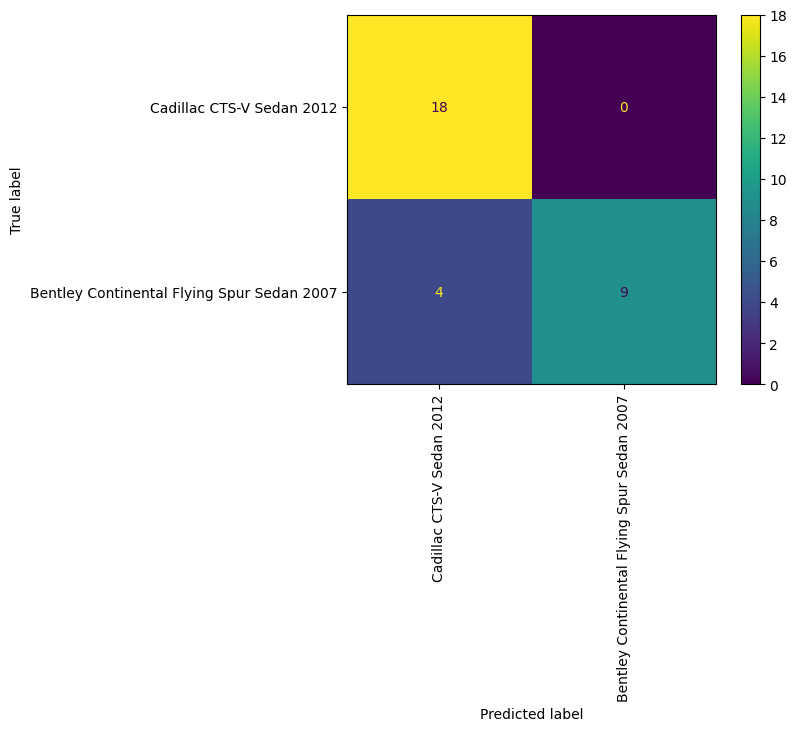

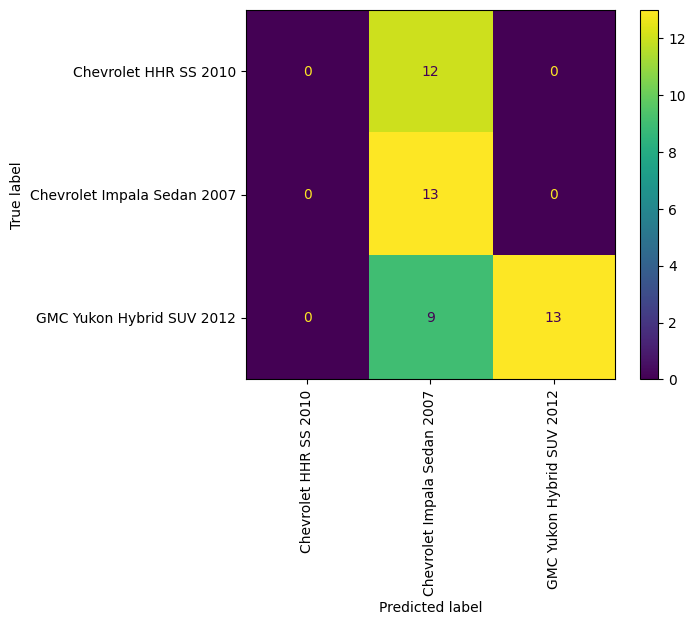

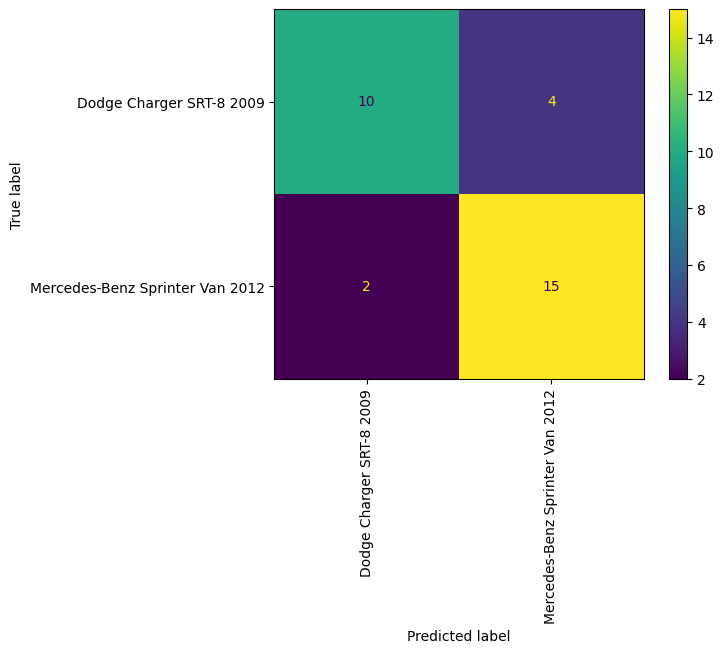

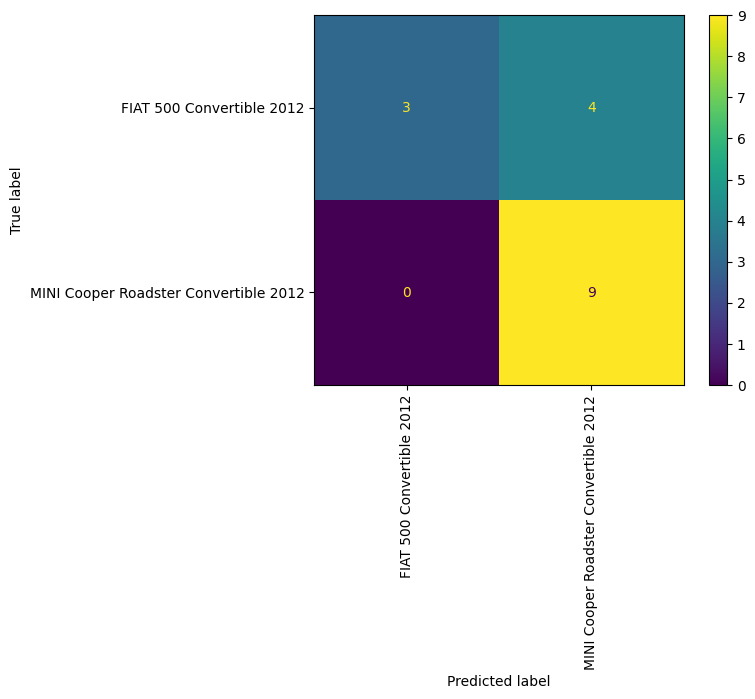

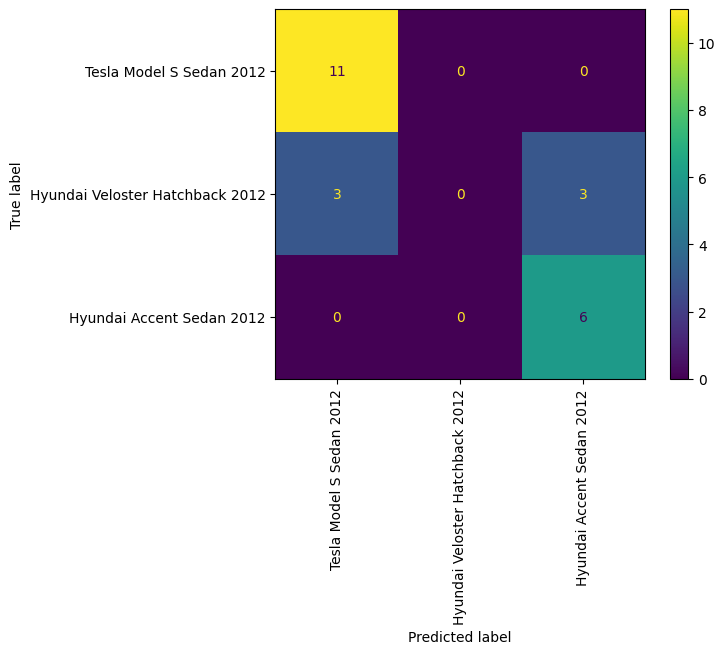

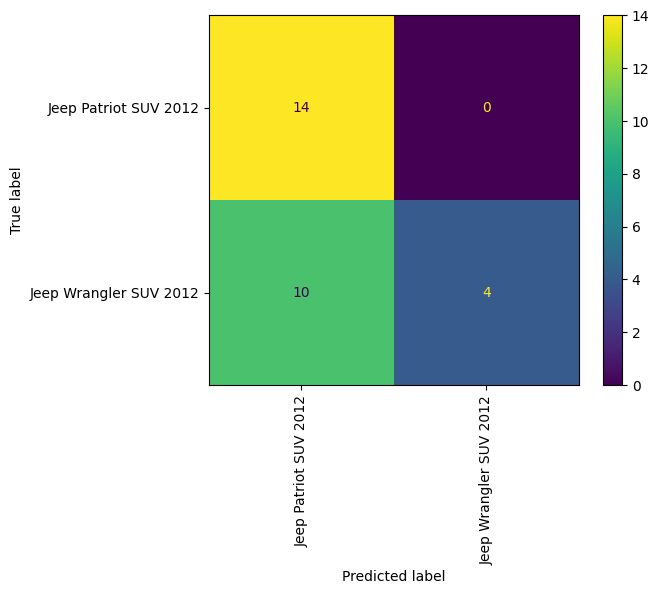

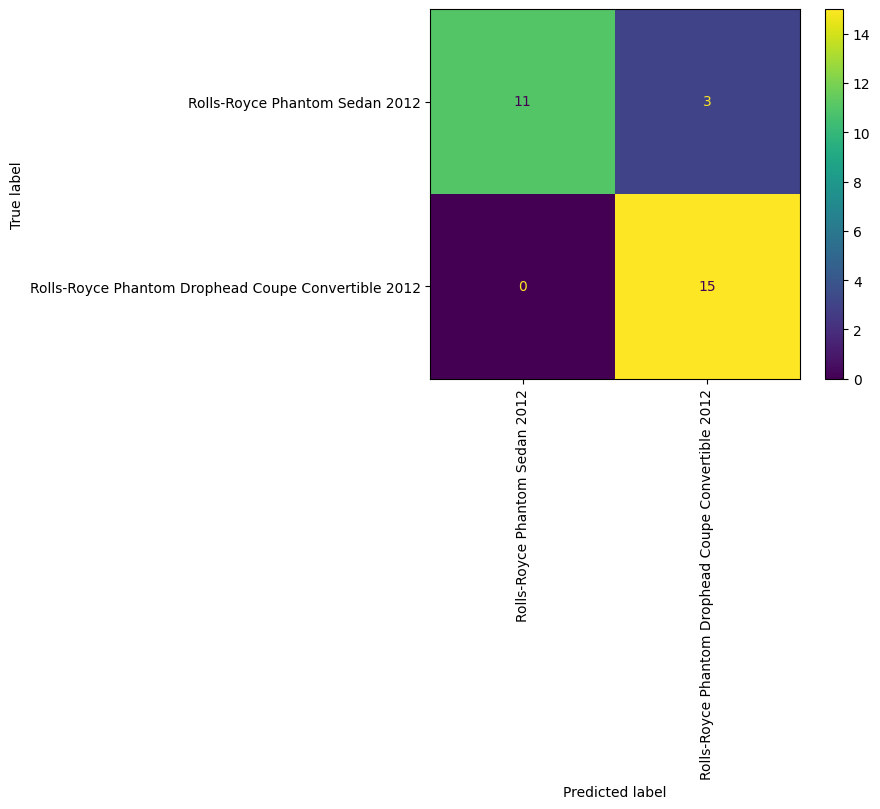

In [34]:
# drop the too big cms
sub_cms, sub_classes = list(zip(*[
    (sub_cm, sub_classes)
    for sub_cm, sub_classes in zip(sub_cms, sub_classes)
    if 1 < sub_cm.shape[0] < 15
]))

print("nb classes :", len(sub_classes))

n_per_line = 1
nrows = math.ceil(len(sub_classes) / n_per_line)

for sub_cm, sub_class, i in zip(sub_cms, sub_classes, range(len(sub_cms))):
    show_cm(sub_cm, sub_class, diag_zero=False, rotation=90)

# Conclusion du premier modèle
Nous avons des perfomances élévées sur notre modèle (90% d'accurac...TOSET). Néanmoins en analysant les valeurs des matrices de confusion, nous pouvons voir que notre modèle a du mal à distinguer des voitures casiment identique visuellement. L'exemple le plus probant est la confusion entre les Audo 100, S6 et TTS Coupe 2012. Après vérification manuel les voitures sont effectivement très proches visuellement. Nous allons donc essayer de créer un modèle plus performant en utilisant un modèle spécifique pour ce type de voitures.

# Définition du modèle basé sur la heatmap

Grace à l'exploration de la heatmap, nous avons remarqué que le modèle se concentre sur certains logo des voitures. Cela peut poser prème pour reconnaitre les voitures de même modele mais d'une année différente. Nous allons donc créer un modèle qui se base sur des images normales et flouté.

## Blur des données 

In [ ]:
import cv2
def generate_blur_image_based_on_heatmap(path:str,kernel_size:Tuple[int,int]=(21,21),sigma:int=10,threshold:int =10):
    
    loader = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    image = Image.open(path)
    img = loader(image).float()
    img = torch.autograd.Variable(img, requires_grad=True)
    img = img.unsqueeze(0)
    img = img.cuda()
    
    with GradCAMpp(model_generic) as cam_extractor:
      out = model_generic(img)
      activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    result = overlay_mask(image, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.0001)
    
    img_np = np.array(result)
    red_mask = (img_np[:,:,0] > img_np[:,:,1] + threshold) & (img_np[:,:,0] > img_np[:,:,2] + threshold)
    red_mask = red_mask.astype(int)
    mask_img = Image.fromarray(np.uint8(red_mask * 255), 'L')  
    
    # Convert the original PIL image to OpenCV format
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Apply a Gaussian blur to the entire image
    blurred_img_cv = cv2.GaussianBlur(img_cv, kernel_size, sigma)

    blurred_img_pil = Image.fromarray(cv2.cvtColor(blurred_img_cv, cv2.COLOR_BGR2RGB))

    # Use the mask to blend the blurred and original images
    result_img = Image.composite(blurred_img_pil, image, mask_img)
    
    
    #enregistre les images dans un path specifique
    
    path = path.split('.')
    
    if not path[0].endswith("_blur"):
        path[0] = path[0] + "_blur"
        path = ".".join(path)
        
    result_img.save(path)
    
#     Display the result
#     plt.imshow(result_img)
#     plt.title('Image with Blurred Red Areas')
#     plt.axis('off')
#     plt.show()

In [ ]:
import os
import random
from tqdm import tqdm

def process_images_in_folder(folder_path, processing_percentage=20):
    # Get a list of all files in the folder
    all_files = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            image_path = os.path.join(root, filename)
            all_files.append(image_path)

    # Shuffle the list of files
    random.shuffle(all_files)

    # Determine the number of files to process based on the percentage
    num_files_to_process = int(len(all_files) * (processing_percentage / 100.0))

    # Iterate through a subset of files based on the percentage
    for image_path in tqdm(all_files[:num_files_to_process]):
        if not image_path.endswith("_blur.png"):
            try:
                generate_blur_image_based_on_heatmap(image_path)
            except Exception as e:
                pass

# Example usage: Process 20% of the images in "final/train" folder
process_images_in_folder("final/train", processing_percentage=20)

## Récupération des données afin de créer un dataset avec les images normales et blur

In [35]:
batch_size_generic = 32
epochs_generic = 1

## Définition des transformations appliquées

In [36]:
train_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [37]:
#Chargement des images dans des datasets
path_test = 'final/test'
path_train = 'final/train'

train_dataset = datasets.ImageFolder(root=path_train, transform = train_tfms)

test_dataset = datasets.ImageFolder(root=path_test, transform = test_tfms)

print(f'Train dataset size is {len(train_dataset)}')
print(f'Test dataset size is {len(test_dataset)}')

Train dataset size is 16078
Test dataset size is 3312


In [38]:
#Convertion des datasets en dataLoader
train_loader_generic = DataLoader(train_dataset, batch_size = batch_size_generic, shuffle=True, num_workers = 2)
test_loader_generic = DataLoader(test_dataset, batch_size = batch_size_generic, shuffle=False, num_workers = 2)

### Chargement du modèle

In [39]:
no_classes_generic = len(train_dataset.classes) # Nombre de classes
model_generic = models.resnet18(pretrained=True)
num_ftrs = model_generic.fc.in_features

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Changememt du dernier layer pour l'adapté à notre problématique

In [40]:
model_generic.fc = nn.Linear(num_ftrs, no_classes_generic)
model_generic = model_generic.to(device)

# Définition de la fonction de Loss et de l'optimisation
criterion_generic = nn.CrossEntropyLoss()
optimizer_generic = optim.SGD(model_generic.parameters(), lr=0.01, momentum=0.9)

lrscheduler_generic = optim.lr_scheduler.ReduceLROnPlateau(optimizer_generic, mode='max', patience=3, threshold = 0.9)

### Définition des fonctions de train et d'évaluation

In [41]:
def eval_model(model, test_loader, device, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader), 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    test_acc = 100.0 * correct / total
    print('Accuracy sur le dataset de test: %d %%' % (
        test_acc))
    return test_acc

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        
        for i, data in enumerate(tqdm(train_loader), 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==preds).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Fin entraînement')
    return model, losses, accuracies, test_accuracies

### Entrainement du modèle

In [42]:
model_generic, training_losses, training_accs, test_accs = train_model(model_generic, train_loader_generic, 
                            test_loader_generic, criterion_generic, optimizer_generic, lrscheduler_generic, device, n_epochs=epochs_generic)

100%|██████████| 503/503 [02:57<00:00,  2.83it/s]


Epoch 1, duration: 177 s, loss: 3.6173, acc: 22.7634


100%|██████████| 104/104 [00:32<00:00,  3.23it/s]

Accuracy sur le dataset de test: 56 %
Fin entraînement


### Affichage des résultats de l'entrainement

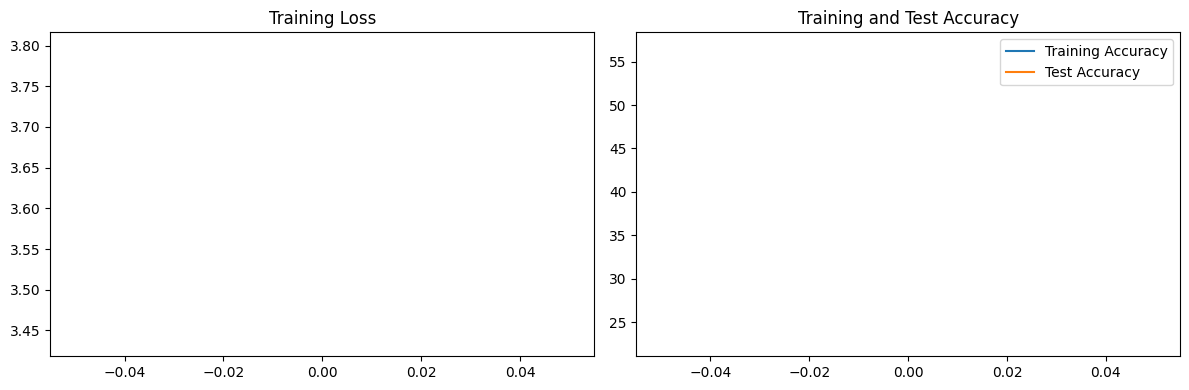

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

### Sauvegarde du modèle

In [44]:
torch.save(model_generic.state_dict(), 'model_blur.pth')

### Évaluation du modèle

Text(0.5, 80.7222222222222, 'Predicted label')

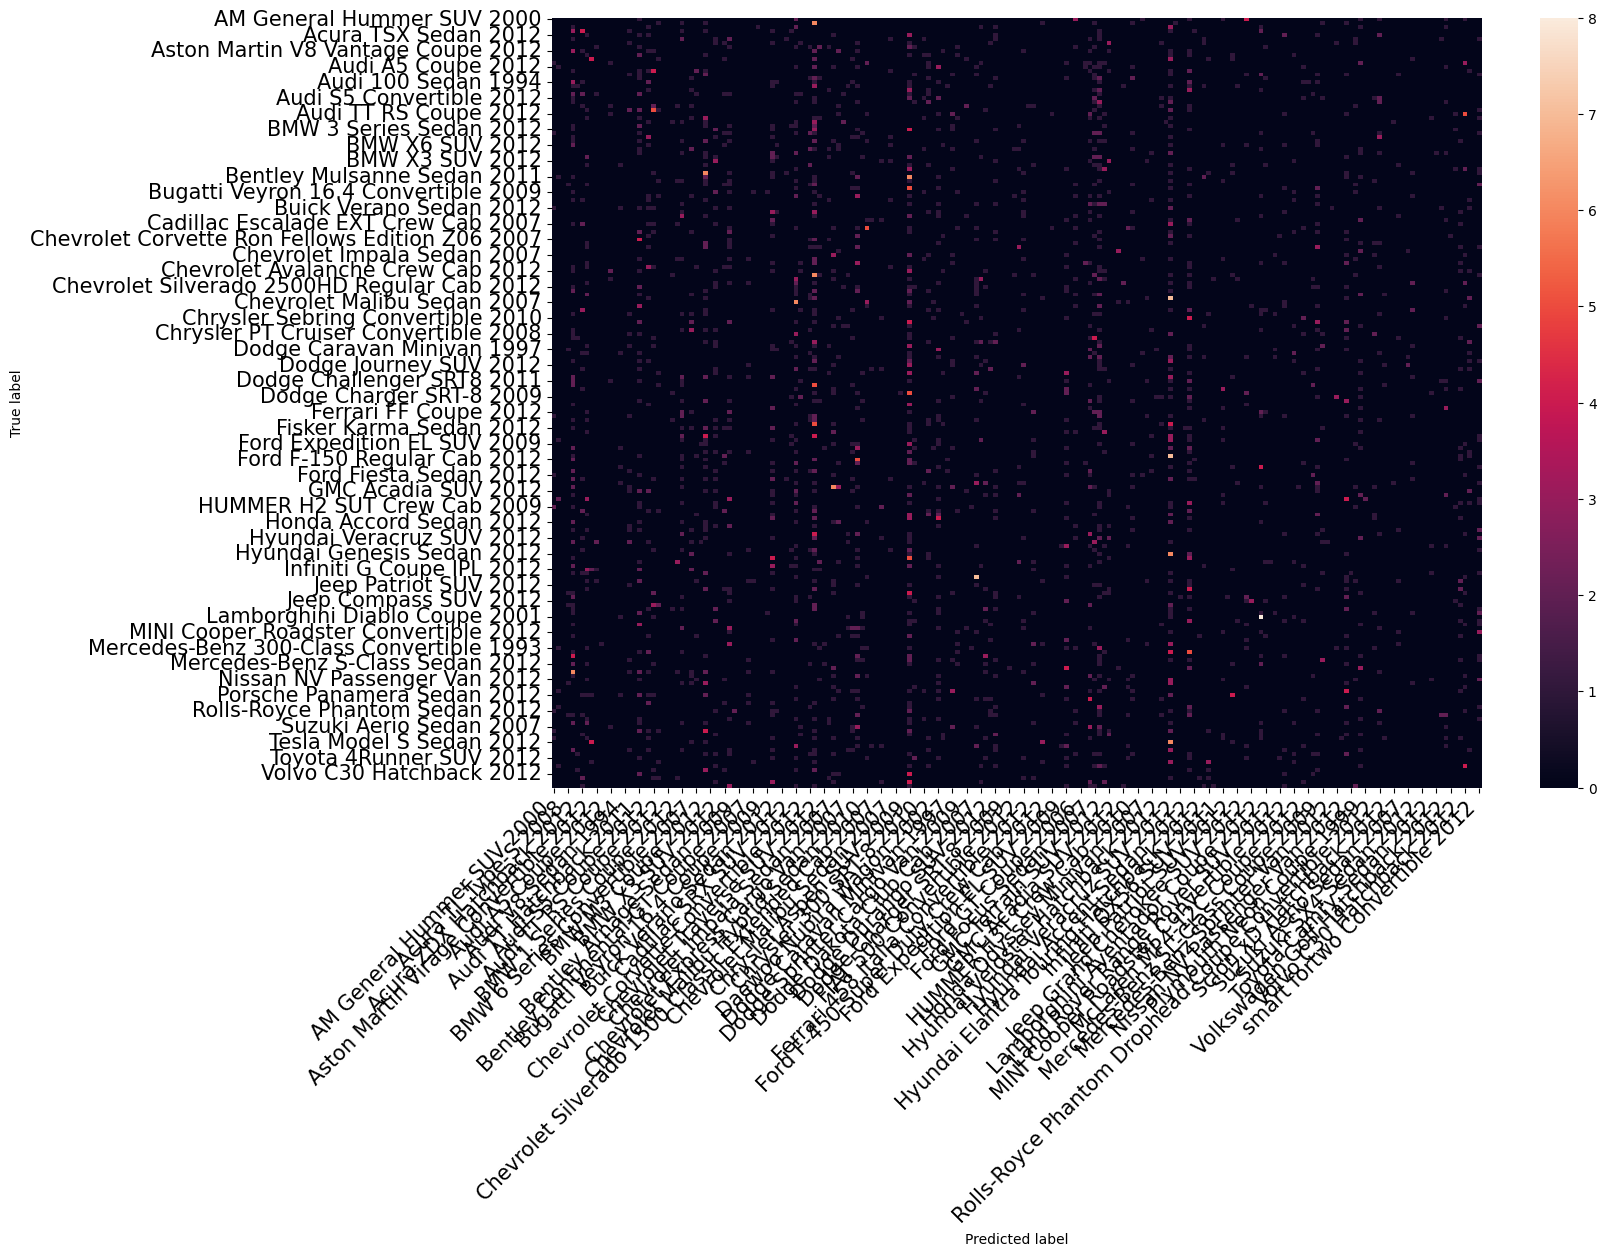

In [45]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader_generic:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_generic(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15,10))

class_names = list(df_names_generic['name'])

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
#Set the diagonal to zero, so we can see the other values better
for i in range(len(df_cm)):
    df_cm.iat[i, i] = 0
heatmap = sns.heatmap(df_cm)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Comparaison avec le précédent modèle

In [47]:
model_generic.eval() # Changement du modèle en mode évaluation

loader = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = '/kaggle/working/final/train/Chevrolet Silverado 1500 Extended Cab 2012/03914_test_blur.jpg' #mettre une vraie image random et intégrer l'explicabilité ici
image = Image.open(random_image_name)

img = loader(image).float()
img = torch.autograd.Variable(img, requires_grad=True)
img = img.unsqueeze(0)
img = img.cuda()



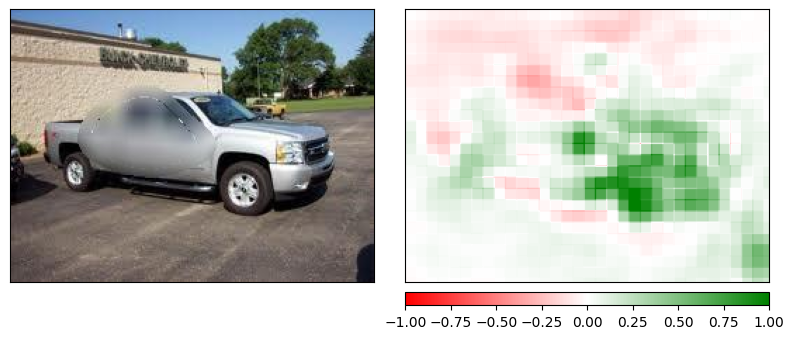

In [48]:
output = model_generic(img)
output = F.softmax(output, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
occlusion = Occlusion(model_generic)

attributions_occ = occlusion.attribute(img,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ, (1,2,0)),
                             original_image=np.asarray(image),
                             methods=["original_image","heat_map"],
                             signs=["all","all"],
                             show_colorbar=True)

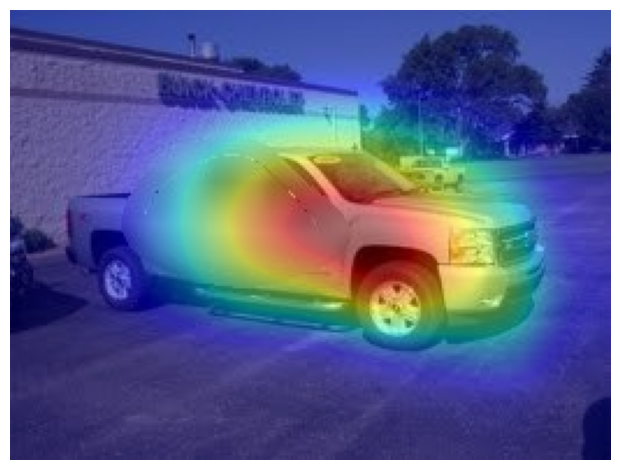

In [49]:
with GradCAMpp(model_generic) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model_generic(img)
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(image, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

# Définition du modèle spécifique

#### Génération du dataset

In [ ]:
# Define source and destination directories
source_train = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train"
source_test = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test"
dest_full = "specific/full"
dest_train = "specific/train"
dest_test = "specific/test"

# Create destination directories if they don't exist
for d in [dest_full, dest_train, dest_test]:
    os.makedirs(d, exist_ok=True)
    
class_to_keep = ["Audi TT RS Coupe 2012", "Audi RS 4 Convertible 2008", "Audi A5 Coupe 2012", "Volvo C30 Hatchback 2012"]

# Function to copy and rename images
def copy_rename_images(src_folder, dest_folder, prefix):
    for class_folder in class_to_keep:
        src_class = os.path.join(src_folder, class_folder)
        dest_class = os.path.join(dest_folder, class_folder)
        os.makedirs(dest_class, exist_ok=True)
        for image in os.listdir(src_class):
            img_name, ext = os.path.splitext(image)
            new_name = f"{img_name}_{prefix}{ext}"
            shutil.copy(os.path.join(src_class, image), os.path.join(dest_class, new_name))

# Copy and rename images for full dataset
copy_rename_images(source_train, dest_full, "train")
copy_rename_images(source_test, dest_full, "test")
# Split full dataset into train and test according to train_size
train_size = 0.8
for class_folder in class_to_keep:
    images = os.listdir(os.path.join(dest_full, class_folder))
    split_index = int(len(images) * train_size)
    train_images = images[:split_index]
    test_images = images[split_index:]
    for image in train_images:
        os.makedirs(os.path.join(dest_train, class_folder), exist_ok=True)
        shutil.copy(os.path.join(dest_full, class_folder, image), os.path.join(dest_train, class_folder, image))
    for image in test_images:
        os.makedirs(os.path.join(dest_test, class_folder), exist_ok=True)
        shutil.copy(os.path.join(dest_full, class_folder, image), os.path.join(dest_test, class_folder, image))


#### Récupération des lables du dataset

In [ ]:
df_names_specific= pd.read_csv('/kaggle/input/stanford-car-dataset-by-classes-folder/names.csv', names=['name'])
df_names_specific = df_names_specific[df_names_specific['name'].isin(class_to_keep)].reset_index(drop=True)


#### Définition des hyperparamètres pour le modèle spécifique

In [ ]:
batch_size_specific = 32
epochs_specific = 10

#### Définition des transformations pour le modèle spécifique

In [ ]:
train_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#### Création du jeu de donnée

In [ ]:
#Chargement des images dans des datasets
path_test = 'specific/test'
path_train = 'specific/train'

train_dataset_specific = datasets.ImageFolder(root=path_train, transform = train_tfms)

test_dataset_specific = datasets.ImageFolder(root=path_test, transform = test_tfms)

print(f'Train dataset size is {len(train_dataset_specific)}')
print(f'Test dataset size is {len(test_dataset_specific)}')

In [ ]:
#Convertion des datasets en dataLoader
train_loader_specific = DataLoader(train_dataset_specific, batch_size = batch_size_generic, shuffle=True, num_workers = 2)
test_loader_specific = DataLoader(test_dataset_specific, batch_size = batch_size_generic, shuffle=False, num_workers = 2)

### Chargement du modèle

In [ ]:
no_classes_specific = len(train_dataset_specific.classes) # Nombre de classes
model_specific = models.resnet18(pretrained=True)
num_ftrs = model_specific.fc.in_features

#### Changement du dernier layer pour l'adapter à notre problématique

In [ ]:
model_specific.fc = nn.Linear(num_ftrs, no_classes_generic)
model_specific = model_generic.to(device)

# Définition de la fonction de Loss et de l'optimisation
criterion_specific = nn.CrossEntropyLoss()
optimizer_specific = optim.SGD(model_specific.parameters(), lr=0.01, momentum=0.9)

lrscheduler_specific = optim.lr_scheduler.ReduceLROnPlateau(optimizer_specific, mode='max', patience=3, threshold = 0.9)

#### Entrainement du modèle

In [ ]:
model_specific, training_losses, training_accs, test_accs = train_model(model_specific, train_loader_specific, 
                            test_loader_specific, criterion_specific, optimizer_specific, lrscheduler_specific, device, n_epochs=epochs_specific)

#### Affichage des résultats de l'entrainement

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

#### Sauvegarde du modèle

In [ ]:
torch.save(model_specific.state_dict(), 'model_specific.pth')

#### Évaluation du modèle

In [ ]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader_specific:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_specific(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15,10))

class_names = list(df_names_specific['name'])

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
#Set the diagonal to zero, so we can see the other values better

heatmap = sns.heatmap(df_cm)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Explicabilité du modèle

In [ ]:
model_specific.eval() # Changement du modèle en mode évaluation

loader = transforms.Compose([transforms.Resize((416, 416)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = '/kaggle/working/specific/test/Audi RS 4 Convertible 2008/05897_test.jpg' #mettre une vraie image random et intégrer l'explicabilité ici
image = Image.open(random_image_name)

img = loader(image).float()
img = torch.autograd.Variable(img, requires_grad=True)
img = img.unsqueeze(0)
img = img.cuda()

In [ ]:
output = model_specific(img)
output = F.softmax(output, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
occlusion = Occlusion(model_specific)

attributions_occ = occlusion.attribute(img,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ, (1,2,0)),
                             original_image=np.asarray(image),
                             methods=["original_image","heat_map"],
                             signs=["all","all"],
                             show_colorbar=True)

In [ ]:
with GradCAMpp(model_specific) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model_generic(img)
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(image, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()